In [1]:
using NRIRHOPM, FileIO, Images, Plots, Interpolations, Memento; gr()

  likely near /Users/gnimuc/.julia/v0.5/NIfTI/src/NIfTI.jl:88


Plots.GRBackend()

In [2]:
import NRIRHOPM: constrain!

In [3]:
include("draw2.jl")

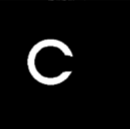

In [4]:
circle = Gray.(load("./ring.png"))

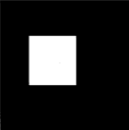

In [5]:
square = Gray.(load("./square.png"))

In [6]:
size(circle), size(square), typeof(circle)

((130,129),(129,130),Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2})

In [7]:
square, circle = restrict(square), restrict(circle); 

In [8]:
fixed, moving = square[1:64,1:64],  circle[1:64,1:64];

In [9]:
function hopm_mixed2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝐌::AbstractMatrix, constraint::Symbol, tol::Real, maxIter::Integer, b::Float64)
    𝐌₀ = copy(𝐌)
    constrain!(𝐌₀, constraint)
    𝐌ᵢ = 𝐌₀
    i = 0
    while i < maxIter
        i += 1
        𝐌ᵢ₊₁ = 𝐭 + b*(𝐓 ⊙ 𝐌ᵢ)
        constrain!(𝐌ᵢ₊₁, constraint)
        if vecnorm(𝐌ᵢ₊₁ - 𝐌ᵢ) < tol
            𝐌ᵢ = 𝐌ᵢ₊₁
            break
        end
        𝐌ᵢ = 𝐌ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, HOPM might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return sum(𝐌ᵢ .* (𝐭 + b*(𝐓 ⊙ 𝐌ᵢ))), 𝐌ᵢ
end

function hopm_mixed2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝑻::BlockedTensor, 𝐌::AbstractMatrix, constraint::Symbol, tol::Real, maxIter::Integer, b::Float64, c::Float64)
    𝐌₀ = copy(𝐌)
    constrain!(𝐌₀, constraint)
    𝐌ᵢ = 𝐌₀
    i = 0
    while i < maxIter
        i += 1
        𝐌ᵢ₊₁ = 𝐭 + b*(𝐓 ⊙ 𝐌ᵢ) + c*(𝑻 ⊙ 𝐌ᵢ)
        constrain!(𝐌ᵢ₊₁, constraint)
        if vecnorm(𝐌ᵢ₊₁ - 𝐌ᵢ) < tol
            𝐌ᵢ = 𝐌ᵢ₊₁
            break
        end
        𝐌ᵢ = 𝐌ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, HOPM might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return sum(𝐌ᵢ .* (𝐭 + b*(𝐓 ⊙ 𝐌ᵢ) + c*(𝑻 ⊙ 𝐌ᵢ))), 𝐌ᵢ
end

hopm_mixed2 (generic function with 2 methods)

In [10]:
immutable MixHOPM2{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    constraint::Symbol
    tolerance::Tt
    maxIteration::Tm
    a::Float64
end
MixHOPM2(constraint, tolerance, maxIteration,a) = MixHOPM2(hopm_mixed2, constraint, tolerance, maxIteration,a)
MixHOPM2(;constraint=:vecnorm, tolerance=1e-5, maxIteration=300,a=1) = MixHOPM2(constraint, tolerance, maxIteration,a)

immutable MixHOPM3{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    constraint::Symbol
    tolerance::Tt
    maxIteration::Tm
    a::Float64
    b::Float64
end
MixHOPM3(constraint, tolerance, maxIteration,a,b) = MixHOPM3(hopm_mixed2, constraint, tolerance, maxIteration,a,b)
MixHOPM3(;constraint=:vecnorm, tolerance=1e-5, maxIteration=300,a=1,b=1) = MixHOPM3(constraint, tolerance, maxIteration,a,b)

MixHOPM3{F<:Function,Tt<:Real,Tm<:Integer}

In [25]:
# displacements = [SVector(i,j) for i in -3:3, j in -3:3]
# displacements2 = [SVector(i,j) for i in -1:1, j in -1:1]
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo,displacetopo]#, displacements, displacements2]
gridSet = [(32,32),(32,32)] #,(64,64),(128,128)]
originΔ = vecnorm(moving-fixed)
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=0, χ=0, method=MixHOPM(maxIteration=20))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-03-04T11:03:57 | info ]: Start multilevel processing...
[ 2017-03-04T11:03:57 | info ]: Level 1: 
[ 2017-03-04T11:03:57 | info ]: Image Dimension: (64,64)
[ 2017-03-04T11:03:57 | info ]: Grid Dimension: (32,32)
[ 2017-03-04T11:03:57 | info ]: Creating data cost with weight=1: 
[ 2017-03-04T11:03:58 | info ]:   0.366799 seconds (2.89 M allocations: 81.664 MB, 5.69% gc time)
[ 2017-03-04T11:03:58 | info ]: Creating smooth cost with weight=0: 
[ 2017-03-04T11:03:58 | info ]:   0.000413 seconds (34 allocations: 167.172 KB)
[ 2017-03-04T11:03:58 | info ]: Optimizing via High Order Power Method: 
[ 2017-03-04T11:03:58 | info ]: HOPM converges in 2 steps.
[ 2017-03-04T11:03:58 | info ]:   0.172530 seconds (2.20 k allocations: 7.799 MB, 9.31% gc time)
[ 2017-03-04T11:03:58 | info ]: Multilevel processing done!


7.639769802477274

In [18]:
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo]
gridSet = [(32,32)]
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=1, χ=70, method=MixHOPM(maxIteration=40))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-03-04T10:51:32 | info ]: Start multilevel processing...
[ 2017-03-04T10:51:32 | info ]: Level 0: 
[ 2017-03-04T10:51:32 | info ]: Image Dimension: (64,64)
[ 2017-03-04T10:51:32 | info ]: Grid Dimension: (32,32)
[ 2017-03-04T10:51:32 | info ]: Creating data cost with weight=1: 
[ 2017-03-04T10:51:32 | info ]:   0.344697 seconds (2.89 M allocations: 81.664 MB, 8.65% gc time)
[ 2017-03-04T10:51:32 | info ]: Creating smooth cost with weight=1: 
[ 2017-03-04T10:51:32 | info ]:   0.000365 seconds (34 allocations: 167.172 KB)
[ 2017-03-04T10:51:32 | info ]: Creating topology cost with weight=70: 
[ 2017-03-04T10:51:33 | info ]:   0.027920 seconds (97 allocations: 7.373 MB)
[ 2017-03-04T10:51:33 | info ]: Optimizing via High Order Power Method: 
[ 2017-03-04T10:54:34 | info ]: HOPM converges in 39 steps.
[ 2017-03-04T10:54:39 | info ]: 186.095468 seconds (4.06 k allocations: 245.972 MB, 0.02% gc time)
[ 2017-03-04T10:54:39 | info ]: Multilevel processing done!


6.474473318736034

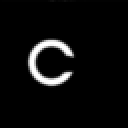

In [26]:
colorview(Gray, warpped[1])

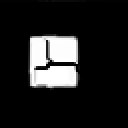

In [27]:
colorview(Gray, warpped[end])

In [28]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # temp

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 30 
 
 
 34 
 
 
 38 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 54 
 
 
 58 
 
 
 1 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 30 
 
 
 34 
 
 
 38 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 54 
 
 
 58 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.341,284.952 26.6043,280.022 21.8676,275.092 21.7148,274.857 21.7148,274.779 21.7148,274.7 21.7148,274.622 21.7148,274.544 21.7148,274.466 21.7148,270.162 
 21.7148,265.232 21.7148,260.301 21.7148,255.371 21.7148,250.441 21.7148,245.511 21.7148,240.581 21.7148,235.651 21.7148,230.721 21.7148,225.791 21.7148,220.861 
 21.7148,215.931 21.7148,211.001 21.7148,206.071 21.7148,201.14 21.7148,196.21 21.7148,191.28 21.7148,186.35 21.7148,181.42 21.7148,176.49 21.7148,171.56 
 21.7148,166.63 21.7148,161.7 21.7148,156.77 21.7148,151.84 21.7148,146.909 21.7148,141.979 21.7148,137.049 21.7148,132.119 21.7148,127.189 21.7148,122.259 
 21.7148,117.329 21.7148,112.399 21.7148,107.469 21.7148,102.539 21.7148,97.6086 21.7148,92.6785 21.7148,87.7485 21.7148,82.8184 21.7148,77.8883 21.7148,72.9582 
 21.7148,68.0281 21.7148,63.098 21.7148,58.1679 21.7148,53.2379 21.7148,48.3078 21.7148,43.3777 21.7148,38.4476 21.7148,33.5175 21.7148,28.5874 21.7148,23.6573 
 21.7148,18.7273 21.7148,13.7972 21.7148,8.86709 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.4174,284.952 26.6807,280.022 21.944,275.092 21.7912,274.857 21.7912,274.779 21.7912,274.7 21.7912,274.622 21.7912,274.544 21.7912,274.466 21.7912,270.162 
 21.7912,265.232 21.7912,260.301 21.7912,255.371 21.7912,250.441 21.7912,245.511 21.7912,240.581 21.7912,235.651 21.7912,230.721 21.7912,225.791 21.7912,220.861 
 21.7912,215.931 21.7912,211.001 21.7912,206.071 21.7912,201.14 21.7912,196.21 21.7912,191.28 21.7912,186.35 21.7912,181.42 21.7912,176.49 21.7912,171.56 
 21.7912,166.63 21.7912,161.7 21.7912,156.77 21.7912,151.84 21.7912,146.909 21.7912,141.979 21.7912,137.049 21.7912,132.119 21.7912,127.189 21.7912,122.259 
 21.7912,117.329 21.7912,112.399 21.7912,107.469 21.7912,102.539 21.7912,97.6086 21.7912,92.6785 21.7912,87.7485 21.7912,82.8184 21.7912,77.8883 21.7912,72.9582 
 21.7912,68.0281 21.7912,63.098 21.7912,58.1679 21.7912,53.2379 21.7912,48.3078 21.7912,43.3777 21.7912,38.4476 21.7912,33.5175 21.7912,28.5874 21.7912,23.6573 
 21.7912,18.7273 21.7912,13.7972 21.7912,8.86709 21.7912,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.4938,284.952 26.7571,280.022 22.0204,275.092 21.8676,274.857 21.8676,274.779 21.8676,274.7 21.8676,274.622 21.8676,274.544 21.8676,274.466 21.8676,270.162 
 21.8676,265.232 21.8676,260.301 21.8676,255.371 21.8676,250.441 21.8676,245.511 21.8676,240.581 21.8676,235.651 21.8676,230.721 21.8676,225.791 21.8676,220.861 
 21.8676,215.931 21.8676,211.001 21.8676,206.071 21.8676,201.14 21.8676,196.21 21.8676,191.28 21.8676,186.35 21.8676,181.42 21.8676,176.49 21.8676,171.56 
 21.8676,166.63 21.8676,161.7 21.8676,156.77 21.8676,151.84 21.8676,146.909 21.8676,141.979 21.8676,137.049 21.8676,132.119 21.8676,127.189 21.8676,122.259 
 21.8676,117.329 21.8676,112.399 21.8676,107.469 21.8676,102.539 21.8676,97.6086 21.8676,92.6785 21.8676,87.7485 21.8676,82.8184 21.8676,77.8883 21.8676,72.9582 
 21.8676,68.0281 21.8676,63.098 21.8676,58.1679 21.8676,53.2379 21.8676,48.3078 21.8676,43.3777 21.8676,38.4476 21.8676,33.5175 21.8676,28.5874 21.8676,23.6573 
 21.8676,18.7273 21.8676,13.7972 21.8676,8.86709 21.8676,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.5702,284.952 26.8335,280.022 22.0968,275.092 21.944,274

In [29]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) #  only similarity measure

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 30 
 
 
 34 
 
 
 38 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 54 
 
 
 58 
 
 
 1 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 30 
 
 
 34 
 
 
 38 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 54 
 
 
 58 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.341,284.952 26.6043,280.022 21.8676,275.092 21.7148,274.857 21.7148,274.779 21.7148,274.7 21.7148,274.622 21.7148,274.544 21.7148,274.466 21.7148,270.162 
 21.7148,265.232 21.7148,260.301 21.7148,255.371 21.7148,250.441 21.7148,245.511 21.7148,240.581 21.7148,235.651 21.7148,230.721 21.7148,225.791 21.7148,220.861 
 21.7148,215.931 21.7148,211.001 21.7148,206.071 21.7148,201.14 21.7148,196.21 21.7148,191.28 21.7148,186.35 21.7148,181.42 21.7148,176.49 21.7148,171.56 
 21.7148,166.63 21.7148,161.7 21.7148,156.77 21.7148,151.84 21.7148,146.909 21.7148,141.979 21.7148,137.049 21.7148,132.119 21.7148,127.189 21.7148,122.259 
 21.7148,117.329 21.7148,112.399 21.7148,107.469 21.7148,102.539 21.7148,97.6086 21.7148,92.6785 21.7148,87.7485 21.7148,82.8184 21.7148,77.8883 21.7148,72.9582 
 21.7148,68.0281 21.7148,63.098 21.7148,58.1679 21.7148,53.2379 21.7148,48.3078 21.7148,43.3777 21.7148,38.4476 21.7148,33.5175 21.7148,28.5874 21.7148,23.6573 
 21.7148,18.7273 21.7148,13.7972 21.7148,8.86709 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.4174,284.952 26.6807,280.022 21.944,275.092 21.7912,274.857 21.7912,274.779 21.7912,274.7 21.7912,274.622 21.7912,274.544 21.7912,274.466 21.7912,270.162 
 21.7912,265.232 21.7912,260.301 21.7912,255.371 21.7912,250.441 21.7912,245.511 21.7912,240.581 21.7912,235.651 21.7912,230.721 21.7912,225.791 21.7912,220.861 
 21.7912,215.931 21.7912,211.001 21.7912,206.071 21.7912,201.14 21.7912,196.21 21.7912,191.28 21.7912,186.35 21.7912,181.42 21.7912,176.49 21.7912,171.56 
 21.7912,166.63 21.7912,161.7 21.7912,156.77 21.7912,151.84 21.7912,146.909 21.7912,141.979 21.7912,137.049 21.7912,132.119 21.7912,127.189 21.7912,122.259 
 21.7912,117.329 21.7912,112.399 21.7912,107.469 21.7912,102.539 21.7912,97.6086 21.7912,92.6785 21.7912,87.7485 21.7912,82.8184 21.7912,77.8883 21.7912,72.9582 
 21.7912,68.0281 21.7912,63.098 21.7912,58.1679 21.7912,53.2379 21.7912,48.3078 21.7912,43.3777 21.7912,38.4476 21.7912,33.5175 21.7912,28.5874 21.7912,23.6573 
 21.7912,18.7273 21.7912,13.7972 21.7912,8.86709 21.7912,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.4938,284.952 26.7571,280.022 22.0204,275.092 21.8676,274.857 21.8676,274.779 21.8676,274.7 21.8676,274.622 21.8676,274.544 21.8676,274.466 21.8676,270.162 
 21.8676,265.232 21.8676,260.301 21.8676,255.371 21.8676,250.441 21.8676,245.511 21.8676,240.581 21.8676,235.651 21.8676,230.721 21.8676,225.791 21.8676,220.861 
 21.8676,215.931 21.8676,211.001 21.8676,206.071 21.8676,201.14 21.8676,196.21 21.8676,191.28 21.8676,186.35 21.8676,181.42 21.8676,176.49 21.8676,171.56 
 21.8676,166.63 21.8676,161.7 21.8676,156.77 21.8676,151.84 21.8676,146.909 21.8676,141.979 21.8676,137.049 21.8676,132.119 21.8676,127.189 21.8676,122.259 
 21.8676,117.329 21.8676,112.399 21.8676,107.469 21.8676,102.539 21.8676,97.6086 21.8676,92.6785 21.8676,87.7485 21.8676,82.8184 21.8676,77.8883 21.8676,72.9582 
 21.8676,68.0281 21.8676,63.098 21.8676,58.1679 21.8676,53.2379 21.8676,48.3078 21.8676,43.3777 21.8676,38.4476 21.8676,33.5175 21.8676,28.5874 21.8676,23.6573 
 21.8676,18.7273 21.8676,13.7972 21.8676,8.86709 21.8676,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.5702,284.952 26.8335,280.022 22.0968,275.092 21.944,274

In [17]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # β=0, χ=70, method=MixHOPM(maxIteration=40)) 6.40

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 29 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 44 
 
 
 48 
 
 
 52 
 
 
 56 
 
 
 60 
 
 
 5 
 
 
 9 
 
 
 13 
 
 
 17 
 
 
 21 
 
 
 25 
 
 
 29 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 44 
 
 
 48 
 
 
 52 
 
 
 56 
 
 
 60 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,284.871 21.7148,284.79 21.7148,279.843 21.7148,274.733 21.7148,274.328 21.7148,274.247 21.7148,269.624 21.7148,264.514 21.7148,259.405 
 21.7148,254.296 21.7148,249.186 21.7148,244.077 21.7148,238.968 21.7148,233.858 21.7148,228.749 21.7148,223.64 21.7148,218.53 21.7148,213.421 21.7148,208.311 
 21.7148,203.202 21.7148,198.093 21.7148,192.983 21.7148,187.874 21.7148,182.765 21.7148,177.655 21.7148,172.546 21.7148,167.437 21.7148,162.327 21.7148,157.218 
 21.7148,152.108 21.7148,146.999 21.7148,141.89 21.7148,136.78 21.7148,131.671 21.7148,126.562 21.7148,121.452 21.7148,116.343 21.7148,111.234 21.7148,106.124 
 21.7148,101.015 21.7148,95.9055 21.7148,90.7962 21.7148,85.6868 21.7148,80.5774 21.7148,75.4681 21.7148,70.3587 21.7148,65.2493 21.7148,60.14 21.7148,55.0306 
 21.7148,49.9213 21.7148,44.8119 21.7148,39.7025 21.7148,34.5932 21.7148,29.4838 21.7148,24.3745 21.7148,19.2651 21.7148,14.6423 21.7148,14.5612 21.7148,14.1557 
 21.7148,9.04637 21.7148,4.09921 21.7148,4.01811 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.794,284.952 21.794,284.871 21.794,284.79 21.794,279.843 21.794,274.733 21.794,274.328 21.794,274.247 21.794,269.624 21.794,264.514 21.794,259.405 
 21.794,254.296 21.794,249.186 21.794,244.077 21.794,238.968 21.794,233.858 21.794,228.749 21.794,223.64 21.794,218.53 21.794,213.421 21.794,208.311 
 21.794,203.202 21.794,198.093 21.794,192.983 21.794,187.874 21.794,182.765 21.794,177.655 21.794,172.546 21.794,167.437 21.794,162.327 21.794,157.218 
 21.794,152.108 21.794,146.999 21.794,141.89 21.794,136.78 21.794,131.671 21.794,126.562 21.794,121.452 21.794,116.343 21.794,111.234 21.794,106.124 
 21.794,101.015 21.794,95.9055 21.794,90.7962 21.794,85.6868 21.794,80.5774 21.794,75.4681 21.794,70.3587 21.794,65.2493 21.794,60.14 21.794,55.0306 
 21.794,49.9213 21.794,44.8119 21.794,39.7025 21.794,34.5932 21.794,29.4838 21.794,24.3745 21.794,19.2651 21.794,14.6423 21.794,14.5612 21.794,14.1557 
 21.794,9.04637 21.794,4.09921 21.794,4.01811 21.794,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.8731,284.952 21.8731,284.871 21.8731,284.79 21.8731,279.843 21.8731,274.733 21.8731,274.328 21.8731,274.247 21.8731,269.624 21.8731,264.514 21.8731,259.405 
 21.8731,254.296 21.8731,249.186 21.8731,244.077 21.8731,238.968 21.8731,233.858 21.8731,228.749 21.8731,223.64 21.8731,218.53 21.8731,213.421 21.8731,208.311 
 21.8731,203.202 21.8731,198.093 21.8731,192.983 21.8731,187.874 21.8731,182.765 21.8731,177.655 21.8731,172.546 21.8731,167.437 21.8731,162.327 21.8731,157.218 
 21.8731,152.108 21.8731,146.999 21.8731,141.89 21.8731,136.78 21.8731,131.671 21.8731,126.562 21.8731,121.452 21.8731,116.343 21.8731,111.234 21.8731,106.124 
 21.8731,101.015 21.8731,95.9055 21.8731,90.7962 21.8731,85.6868 21.8731,80.5774 21.8731,75.4681 21.8731,70.3587 21.8731,65.2493 21.8731,60.14 21.8731,55.0306 
 21.8731,49.9213 21.8731,44.8119 21.8731,39.7025 21.8731,34.5932 21.8731,29.4838 21.8731,24.3745 21.8731,19.2651 21.8731,14.6423 21.8731,14.5612 21.8731,14.1557 
 21.8731,9.04637 21.8731,4.09921 21.8731,4.01811 21.8731,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.7029,284.952 26.7029,284.871 26.7029,284.79 24.4407,279.843 22.1031,274.733 21.9523,274.328

In [21]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # β=1, χ=70, method=MixHOPM(maxIteration=40)) 6.47

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 15 
 
 
 19 
 
 
 23 
 
 
 27 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 44 
 
 
 48 
 
 
 52 
 
 
 56 
 
 
 60 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,284.952 31.0147,280.022 31.0147,275.092 31.0147,270.162 31.0147,265.232 31.0147,264.84 31.0147,264.762 31.0147,260.301 31.0147,255.371 31.0147,250.441 
 31.0147,245.511 31.0147,240.581 31.0147,235.651 31.0147,230.721 31.0147,225.791 31.0147,220.861 31.0147,215.931 31.0147,211.001 31.0147,206.071 31.0147,201.14 
 31.0147,196.21 31.0147,191.28 31.0147,186.35 31.0147,181.42 31.0147,176.49 31.0147,171.56 31.0147,166.63 31.0147,161.7 31.0147,156.77 31.0147,151.84 
 31.0147,146.909 31.0147,141.979 31.0147,137.049 31.0147,132.119 31.0147,127.189 31.0147,122.259 31.0147,117.329 31.0147,112.399 31.0147,107.469 31.0147,102.539 
 31.0147,97.6086 31.0147,92.6785 31.0147,87.7485 31.0147,82.8184 31.0147,77.8883 31.0147,72.9582 31.0147,68.0281 31.0147,63.098 31.0147,58.1679 31.0147,53.2379 
 31.0147,48.3078 31.0147,43.3777 31.0147,38.4476 31.0147,33.5175 31.0147,28.5874 31.0147,23.6573 31.0147,18.7273 31.0147,14.2667 31.0147,14.1885 31.0147,13.7972 
 31.0147,8.86709 30.8671,4.09352 26.2909,4.01526 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0885,280.1 31.0885,277.557 31.0885,275.015 31.0885,270.162 31.0885,265.232 31.0885,264.84 31.0885,264.762 31.0885,260.301 31.0885,255.371 31.0885,250.441 
 31.0885,245.511 31.0885,240.581 31.0885,235.651 31.0885,230.721 31.0885,225.791 31.0885,220.861 31.0885,215.931 31.0885,211.001 31.0885,206.071 31.0885,201.14 
 31.0885,196.21 31.0885,191.28 31.0885,186.35 31.0885,181.42 31.0885,176.49 31.0885,171.56 31.0885,166.63 31.0885,161.7 31.0885,156.77 31.0885,151.84 
 31.0885,146.909 31.0885,141.979 31.0885,137.049 31.0885,132.119 31.0885,127.189 31.0885,122.259 31.0885,117.329 31.0885,112.399 31.0885,107.469 31.0885,102.539 
 31.0885,97.6086 31.0885,92.6785 31.0885,87.7485 31.0885,82.8184 31.0885,77.8883 31.0885,72.9582 31.0885,68.0281 31.0885,63.098 31.0885,58.1679 31.0885,53.2379 
 31.0885,48.3078 31.0885,43.3777 31.0885,38.4476 31.0885,33.5175 31.0885,28.5874 31.0885,23.6573 31.0885,18.7273 31.0885,14.2667 31.0885,14.1885 31.0885,13.7972 
 31.0885,8.86709 31.0136,4.09352 28.6892,4.01526 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.1623,275.248 31.1623,275.093 31.1623,274.938 31.1623,270.162 31.1623,265.232 31.1623,264.84 31.1623,264.762 31.1623,260.301 31.1623,255.371 31.1623,250.441 
 31.1623,245.511 31.1623,240.581 31.1623,235.651 31.1623,230.721 31.1623,225.791 31.1623,220.861 31.1623,215.931 31.1623,211.001 31.1623,206.071 31.1623,201.14 
 31.1623,196.21 31.1623,191.28 31.1623,186.35 31.1623,181.42 31.1623,176.49 31.1623,171.56 31.1623,166.63 31.1623,161.7 31.1623,156.77 31.1623,151.84 
 31.1623,146.909 31.1623,141.979 31.1623,137.049 31.1623,132.119 31.1623,127.189 31.1623,122.259 31.1623,117.329 31.1623,112.399 31.1623,107.469 31.1623,102.539 
 31.1623,97.6086 31.1623,92.6785 31.1623,87.7485 31.1623,82.8184 31.1623,77.8883 31.1623,72.9582 31.1623,68.0281 31.1623,63.098 31.1623,58.1679 31.1623,53.2379 
 31.1623,48.3078 31.1623,43.3777 31.1623,38.4476 31.1623,33.5175 31.1623,28.5874 31.1623,23.6573 31.1623,18.7273 31.1623,14.2667 31.1623,14.1885 31.1623,13.7972 
 31.1623,8.86709 31.16,4.09352 31.0874,4.01526 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,275.092 35.6647,275.013 35.6647,274.935 33.5559

In [24]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # β=1, χ=0, method=MixHOPM(maxIteration=20) 6.03

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 1 
 
 
 5 
 
 
 10 
 
 
 14 
 
 
 18 
 
 
 23 
 
 
 27 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 45 
 
 
 49 
 
 
 53 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,275.811 21.7148,266.671 21.7148,261.918 21.7148,257.311 21.7148,256.945 21.7148,256.872 21.7148,252.704 21.7148,248.097 21.7148,243.491 
 21.7148,238.884 21.7148,234.277 21.7148,229.67 21.7148,225.063 21.7148,220.457 21.7148,215.85 21.7148,211.243 21.7148,206.636 21.7148,202.029 21.7148,197.423 
 21.7148,192.816 21.7148,188.209 21.7148,183.602 21.7148,178.995 21.7148,174.389 21.7148,169.782 21.7148,165.175 21.7148,160.568 21.7148,155.961 21.7148,151.355 
 21.7148,146.748 21.7148,142.141 21.7148,137.534 21.7148,132.927 21.7148,128.321 21.7148,123.714 21.7148,119.107 21.7148,114.5 21.7148,109.893 21.7148,105.287 
 21.7148,100.68 21.7148,96.073 21.7148,91.4662 21.7148,86.8594 21.7148,82.2526 21.7148,77.6458 21.7148,73.039 21.7148,68.4322 21.7148,63.8254 21.7148,59.2186 
 21.7148,54.6118 21.7148,50.005 21.7148,45.3982 21.7148,40.7914 21.7148,36.1846 21.7148,31.5778 21.7148,26.971 21.7148,22.803 21.7148,22.7298 21.7148,22.3642 
 21.7148,17.7574 21.7148,13.1506 21.7148,8.54381 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,280.418 26.3648,273.509 26.3648,266.599 26.3648,261.918 26.3648,257.311 26.3648,256.945 26.3648,256.872 26.3648,252.704 26.3648,248.097 26.3648,243.491 
 26.3648,238.884 26.3648,234.277 26.3648,229.67 26.3648,225.063 26.3648,220.457 26.3648,215.85 26.3648,211.243 26.3648,206.636 26.3648,202.029 26.3648,197.423 
 26.3648,192.816 26.3648,188.209 26.3648,183.602 26.3648,178.995 26.3648,174.389 26.3648,169.782 26.3648,165.175 26.3648,160.568 26.3648,155.961 26.3648,151.355 
 26.3648,146.748 26.3648,142.141 26.3648,137.534 26.3648,132.927 26.3648,128.321 26.3648,123.714 26.3648,119.107 26.3648,114.5 26.3648,109.893 26.3648,105.287 
 26.3648,100.68 26.3648,96.073 26.3648,91.4662 26.3648,86.8594 26.3648,82.2526 26.3648,77.6458 26.3648,73.039 26.3648,68.4322 26.3648,63.8254 26.3648,59.2186 
 26.3648,54.6118 26.3648,50.005 26.3648,45.3982 26.3648,40.7914 26.3648,36.1846 26.3648,31.5778 26.3648,26.971 26.3648,22.803 26.3648,22.7298 26.3648,22.3642 
 26.3648,17.7574 26.3648,13.1506 26.3648,8.54381 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,275.885 31.0147,271.206 31.0147,266.527 31.0147,261.918 31.0147,257.311 31.0147,256.945 31.0147,256.872 31.0147,252.704 31.0147,248.097 31.0147,243.491 
 31.0147,238.884 31.0147,234.277 31.0147,229.67 31.0147,225.063 31.0147,220.457 31.0147,215.85 31.0147,211.243 31.0147,206.636 31.0147,202.029 31.0147,197.423 
 31.0147,192.816 31.0147,188.209 31.0147,183.602 31.0147,178.995 31.0147,174.389 31.0147,169.782 31.0147,165.175 31.0147,160.568 31.0147,155.961 31.0147,151.355 
 31.0147,146.748 31.0147,142.141 31.0147,137.534 31.0147,132.927 31.0147,128.321 31.0147,123.714 31.0147,119.107 31.0147,114.5 31.0147,109.893 31.0147,105.287 
 31.0147,100.68 31.0147,96.073 31.0147,91.4662 31.0147,86.8594 31.0147,82.2526 31.0147,77.6458 31.0147,73.039 31.0147,68.4322 31.0147,63.8254 31.0147,59.2186 
 31.0147,54.6118 31.0147,50.005 31.0147,45.3982 31.0147,40.7914 31.0147,36.1846 31.0147,31.5778 31.0147,26.971 31.0147,22.803 31.0147,22.7298 31.0147,22.3642 
 31.0147,17.7574 31.0147,13.1506 31.0147,8.54381 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,275.738 35.6647,271.131 35.6647